## Core Algorithms

## Date: 9/2/22

- link to course on YT and colab notebook: https://www.youtube.com/watch?v=tPYj3fFJGjk
- also check out the intrsuctors github repos for more projects: https://github.com/techwithtim

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from six.moves import urlib

import tensorflow.compat.v2.feature_column as fc

### Linear regression

Use the titanic dataset

In [2]:
#import dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('eval.csv')
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            264 non-null    

In [3]:
#remove target variable from training data
y_train = train.pop('survived')
print(y_train)
y_test = test.pop('survived')

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64


### EDA

In [10]:
train.head()
train.describe()

age  n_siblings_spouses       parch        fare
count  627.000000          627.000000  627.000000  627.000000
mean    29.631308            0.545455    0.379585   34.385399
std     12.511818            1.151090    0.792999   54.597730
min      0.750000            0.000000    0.000000    0.000000
25%     23.000000            0.000000    0.000000    7.895800
50%     28.000000            0.000000    0.000000   15.045800
75%     35.000000            1.000000    0.000000   31.387500
max     80.000000            8.000000    5.000000  512.329200

<AxesSubplot:>

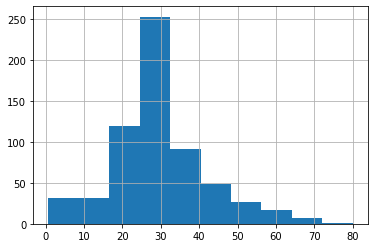

In [12]:
train.age.hist()

<AxesSubplot:>

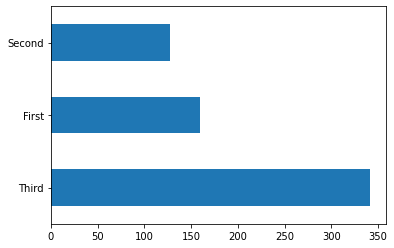

In [15]:
train['class'].value_counts().plot(kind='barh')

<AxesSubplot:>

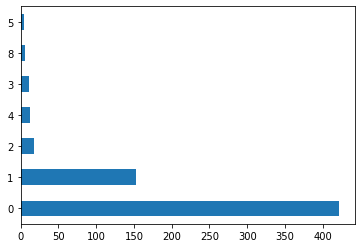

In [16]:
train.n_siblings_spouses.value_counts().plot(kind='barh')

<AxesSubplot:>

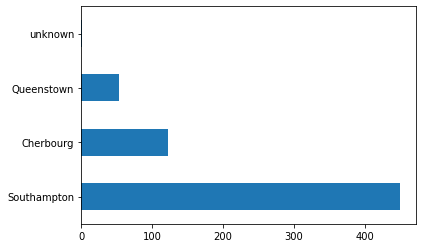

In [18]:
train.embark_town.value_counts().plot(kind='barh')

<AxesSubplot:>

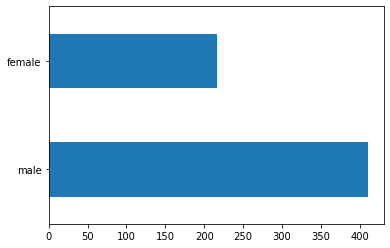

In [19]:
train.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

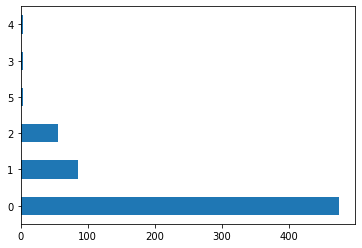

In [20]:
train.parch.value_counts().plot(kind='barh')

In [23]:
train.alone.value_counts()

y    372
n    255
Name: alone, dtype: int64

In [21]:
train.isnull().sum()

sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

### Data transformation - date: 24/3/2022
- Converting categorical values into numeric values
- Refer to the below link 
- https://www.tensorflow.org/tutorials/structured_data/feature_columns 

In [24]:
from tensorflow import feature_column

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


In [26]:
cat_columns = ['class', 'sex', 'embark_town', 'n_siblings_spouses', 'parch', 'deck', 'alone']
numeric_columns = ['age', 'fare']

In [27]:
feature_columns = []

for feature in cat_columns:
    vocab = train[feature].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature, vocab))

for feature in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))

In [28]:
feature_columns

[VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

## Date 29th March, 22
- Epochs are used to iterate over larger datasets to suport for lack of RAM and computational speed. 

### Training process: Input function

In [36]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) #create dataset object with data and output labels
        if shuffle:
            ds = ds.shuffle(1000) #randomise order of data
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

In [37]:
#pass train and test data to the input function
train_input_fn = make_input_fn(train, y_train)
test_input_fn = make_input_fn(test, y_test, num_epochs=1, shuffle=False)

### Linear regression model

In [38]:
train.isnull().sum()

sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [35]:
test.isnull().sum()

sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [39]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpi3n30scg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\user\AppData\Local\Temp\tmpi3n30scg\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 138.359
INFO:tensorflow:loss = 0.44022977, step = 100 (0.723 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into C:\Users\user\AppData\Local\Temp\tmpi3n30scg\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for fi

In [41]:
print(result)

{'accuracy': 0.7386364, 'accuracy_baseline': 0.625, 'auc': 0.8307928, 'auc_precision_recall': 0.79873544, 'average_loss': 0.48340845, 'label/mean': 0.375, 'loss': 0.4766834, 'precision': 0.6530612, 'prediction/mean': 0.41332006, 'recall': 0.64646465, 'global_step': 200}


### Gettng predictions on test data

In [44]:
result = list(linear_est.predict(test_input_fn))
print(y_test[0])
print(result[0]['probabilities'][0])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\user\AppData\Local\Temp\tmpi3n30scg\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
0.8946841
